In [1]:
import os, sys
sys.path.append('../')
import pickle as pkl
import torch
import dgl
from ib.utils import load_data
import json
from tqdm import tqdm

In [2]:
from cong.utils import execute_model2, load_backbone, TestSampler
from cong.ckpt_node_g import node_g_checkpoints
from ib.gib_gnns import GIBGCN, GIBGAT, GIBSAGE, GIBGIN
from ib.utils import load_folds

In [3]:
from dgl.dataloading import GraphDataLoader

In [4]:
import pandas as pd
import numpy as np

In [5]:
import ot
from cm.similarity import build_index, build_class_index, knn, weight_normalize, sim_gausian, eulidean_distance

In [7]:
dataset, num_classes, dim_feats = load_data('MUTAG')

In [8]:
model_map = {
    'GIBGCN': GIBGCN, 
    'GIBSAGE': GIBSAGE, 
    'GIBGIN': GIBGIN,
    'GIBGAT': GIBGAT
}
md = model_map['GIBGIN']
ckpt_infor = node_g_checkpoints['MUTAG']
md_name = md.__qualname__.split('.')[-1]

In [9]:
train, test, val = load_folds(ckpt_infor[md_name]['fold'])

In [10]:
fold = 0
train_idx, test_idx = train[fold], test[fold]
device = torch.device('cuda:0')
ckpt_path = ckpt_infor[md_name]['path']
args = ckpt_infor[md_name]['args']
ckpt_path = ckpt_path.replace("$$$$", str(fold))
backbone = load_backbone(md, ckpt_path, args, device)
backbone.eval()

<class 'ib.gib_gnns.GIBGIN'> ../ib/ckpt/mutag_node_g_fold/IB_MUTAG_GIBGIN_fold0_donsker_nlayer2_nhidden2_bs32_lr0.01_pp0.1_mi0.051693530511_best.pth (7, 2, 2, 32, 'sum', 'softmax', 'node', 1.0)


GIBGIN

In [11]:
batch_size = 32
train_sampler = TestSampler(train_idx)
test_sampler = TestSampler(test_idx)
train_loader = GraphDataLoader(dataset, sampler=train_sampler, batch_size=batch_size)
test_loader = GraphDataLoader(dataset, sampler=test_sampler, batch_size=batch_size)
train_outputs = execute_model2(train_loader, backbone, device)
test_outputs = execute_model2(test_loader, backbone, device)

/home/alexbui/anaconda3/envs/motif/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In [12]:
train_graphs, train_prot_embs, train_labels = train_outputs['graphs'], train_outputs['graph_embs'], train_outputs['labels']
test_graphs, test_prot_embs, test_labels = test_outputs['graphs'], test_outputs['graph_embs'], test_outputs['labels']

In [13]:
index = build_index(train_prot_embs.to('cpu'), num_centroids=2, use_gpu=False)

In [14]:
test_refs = knn(test_prot_embs.to('cpu'), index, k=6)

In [16]:
def emd_similarity(query, context, query_weight, context_weight, gau_scale=1):
    n, _ = query.size()
    m, d = context.size()
    query = query.tile((1, m)).view(n, m, d)
    dis = eulidean_distance(query, context)
    sim = sim_gausian(dis, gau_scale)

    T = ot.sinkhorn(query_weight, context_weight, dis, 0.05, numItermax=100, stopThr=1e-1)
    sim = (T * sim).sum().item()
    return sim, T

In [17]:
tg = test_graphs[-2]
cg = train_graphs[115] 

In [18]:
query = tg.ndata['emb']
query_weight = weight_normalize(tg.ndata['assignment'][:,0])
context = cg.ndata['emb']
context_weight = weight_normalize(cg.ndata['assignment'][:,0])
sim, T1 = emd_similarity(query, context, query_weight, context_weight)

/home/alexbui/anaconda3/envs/motif/lib/python3.11/site-packages/ot/bregman.py:536: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


In [19]:
query = tg.ndata['emb']
query_weight = (torch.ones_like(tg.ndata['assignment'][:,0]) / tg.num_nodes()).to(device)
context = cg.ndata['emb']
context_weight = (torch.ones_like(cg.ndata['assignment'][:,0]) / tg.num_nodes()).to(device)
sim, T2 = emd_similarity(query, context, query_weight, context_weight)

In [49]:
def min_max_normalize(T, threshold=1e-4):
    mn = T.min()
    mx = T.max()
    T = (T - mn) / (mx - mn)
    return (T >= threshold) * T

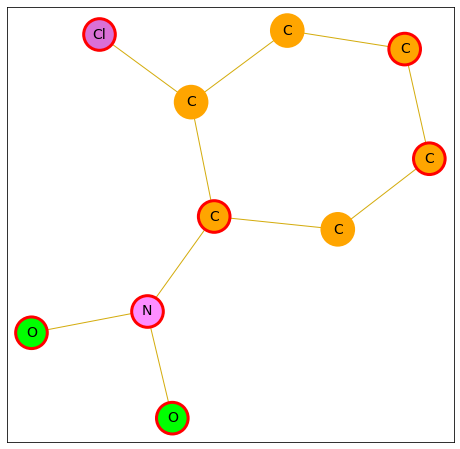

In [401]:
plt.rcParams["figure.figsize"] = [8, 8]
tg_selected_nodes = (tg.ndata['assignment'][:,0].cpu() >= 0.5).nonzero().flatten().tolist()
pos1 = draw_mutag(tg.cpu().remove_self_loop(), tg_selected_nodes, default_color='#D4AC0D', margin=0.01)
plt.savefig('query_graph.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

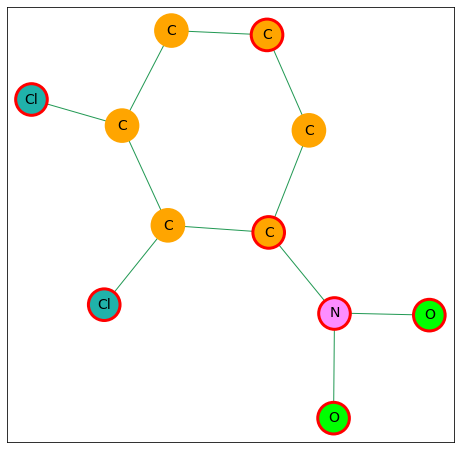

In [405]:
plt.rcParams["figure.figsize"] = [8, 8]
cg_selected_nodes = (cg.ndata['assignment'][:,0].cpu() >= 0.5).nonzero().flatten().tolist()
pos2 = draw_mutag(cg.cpu().remove_self_loop(), cg_selected_nodes, default_color='#229954', margin=0.01)
plt.savefig('context_graph.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

In [300]:
def get_transport_graph(tg, cg, T):
    # prepare edges
    tg1 = tg.remove_self_loop()
    tg1_src, tg1_dst = tg1.edges()
    n1 = tg1.num_nodes()
    cg1 = cg.remove_self_loop()
    cg1_nodes = cg1.nodes() + n1
    cg1_src, cg1_dst = cg1.edges()
    cg1_src, cg1_dst = cg1_src + n1, cg1_dst + n1
    # get transport edges
    T1_norm = min_max_normalize(T, 1e-1).to('cpu')
    transport_edges = (T1_norm > 0).nonzero()
    transport_src, transport_dst = transport_edges[:,0], transport_edges[:,1]
    weights = []
    for s, d in zip(transport_src, transport_dst):
        weights.append(T1_norm[s,d].item() * 10)
    transport_dst += n1
    # prepare final graph edges
    src = torch.cat([tg1_src.cpu(), cg1_src.cpu(), transport_src.cpu()])
    dst = torch.cat([tg1_dst.cpu(), cg1_dst.cpu(), transport_dst.cpu()])
    fg = dgl.graph((src, dst))
    fg.ndata['label'] = torch.cat([tg1.ndata['label'].cpu(), cg1.ndata['label'].cpu()])
    selected_nodes = torch.cat([torch.tensor(tg_selected_nodes), torch.tensor(cg_selected_nodes) + n1]).tolist()
    edge_weights = torch.cat([torch.ones((len(tg1_src),)), torch.ones((len(cg1_src),)), torch.tensor(weights)])
    indicators = torch.cat([torch.zeros((len(tg1_src),)), torch.ones((len(cg1_src),)), torch.ones((len(cg1_src),))*2])
    return fg, selected_nodes, edge_weights, indicators

In [301]:
fg, selected_nodes, edge_weights, indicators = get_transport_graph(tg, cg, T1)

In [404]:
import networkx as nx
import collections
import matplotlib.pyplot as plt

def draw_mutag(g, selected_nodes=None, edge_weights=None, indicators=None, node_size=1000, margin=0.1, pos=None, default_color='grey'):
    node_names = ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br']
    colors = ['orange','#fd8dff','lime','#5cb85c','#06b8ff','lightseagreen','darksalmon']
    gx = dgl.to_networkx(g)
    node_label = g.ndata['label'].flatten().numpy()
    selected_nodes = set(selected_nodes)
    ids = collections.defaultdict(list)
    labels = {}
    edgecolors = collections.defaultdict(list)
    for i, n in enumerate(node_label):
        ids[n].append(i)
        labels[i] = node_names[n]
        bcl = colors[n] if not i in selected_nodes else 'red'
        edgecolors[n].append(bcl)
        
    src, dst = g.edges()
    src, dst = src.numpy(), dst.numpy()
    for i, (s, d) in enumerate(zip(src, dst)):
        if not edge_weights is None:
            gx[s][d][0]['w'] = edge_weights[i]
            gx[s][d][0]['indicator'] = indicators[i]
    
    gx = gx.to_undirected()
    weight = [v for k, v in nx.get_edge_attributes(gx, 'w').items()]
    indicators = [v for k, v in nx.get_edge_attributes(gx, 'indicator').items()]
    if not weight:
        weight = 1
        edge_colors = default_color
        edge_styles = 'solid'
    else:
        edge_colors = []
        edge_styles = []
        for i, w in enumerate(weight):
            if w > 1.0:
                edge_colors.append("red")
                edge_styles.append(":")
            elif indicators:
                if indicators[i] == 0:
                    edge_colors.append('#D4AC0D')
                    edge_styles.append("solid")
                elif indicators[i] == 1:
                    edge_colors.append('#229954')
                    edge_styles.append("solid")
                else:
                    edge_colors.append("red")
                    edge_styles.append("dotted")
            else:
                edge_colors.append(default_color)
    
    if pos is None:
        pos = nx.kamada_kawai_layout(gx)
    ax = plt.subplot()
    ax.margins(margin)
    for k, v in ids.items():
        nx.draw_networkx_nodes(gx, pos, ax=ax, nodelist=v,
                               node_color=colors[k],
                               edgecolors=edgecolors[k],
                               node_size=node_size,
                               linewidths=3)
    nx.draw_networkx_labels(gx, pos, labels, font_size=14, font_color="black")
    nx.draw_networkx_edges(gx, pos, width=weight, edge_color=edge_colors, style=edge_styles)
    return pos

In [394]:
# merge two graph tg & cg into one
n1 = tg.num_nodes()
for k, v in pos2.items():
    pos1[k + n1] = np.array([v[0]-1.8, v[1]+0.5])

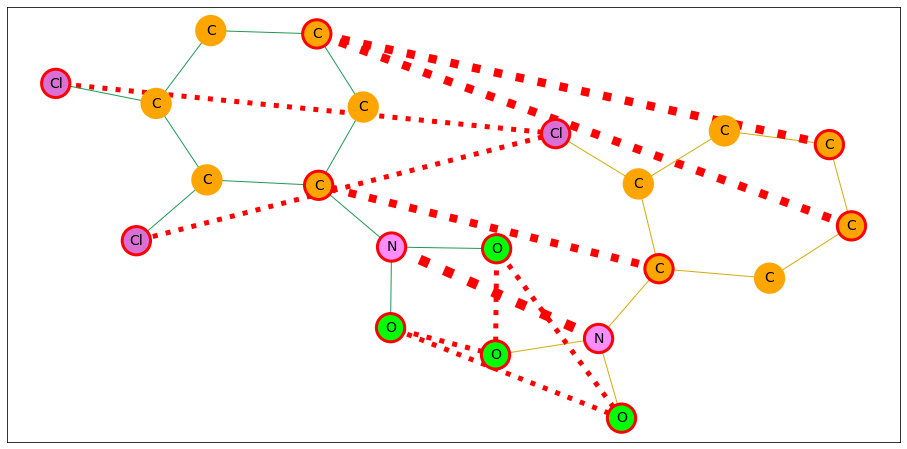

In [395]:
plt.rcParams["figure.figsize"] = [16, 8]
fg.edata['w'] = edge_weights
p = draw_mutag(fg.cpu(), selected_nodes=selected_nodes, edge_weights=edge_weights.tolist(), indicators=indicators, pos=pos1, node_size=800, margin=0.01)
plt.savefig('con_transport.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

In [396]:
fg_uni, selected_nodes_uni, edge_weights_uni, indicators_uni = get_transport_graph(tg, cg, T2)

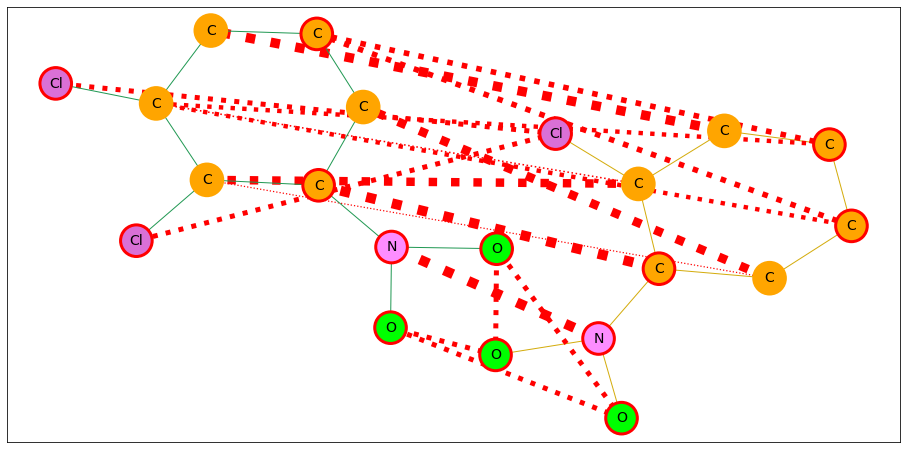

In [397]:
plt.rcParams["figure.figsize"] = [16, 8]
p = draw_mutag(fg_uni.cpu(),
               selected_nodes=selected_nodes_uni,
               edge_weights=edge_weights_uni.tolist(),
               indicators=indicators_uni,
               pos=pos1,
               margin=0.01)
plt.savefig('uni_transport.pdf', format='pdf', bbox_inches='tight', pad_inches=0)